In [3]:
!pip install detecto

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import albumentations as A

from tqdm.notebook import tqdm
from detecto import core, utils, visualize
from glob import glob
from detecto.utils import _is_iterable, read_image
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
from IPython.display import clear_output
from detecto.core import DataLoader, Model
from torchvision import transforms
from torchmetrics.detection.mean_ap import MeanAveragePrecision

Следующие фуннкции были написаны в библиотеке `Detecto`, но у `rreverse_normilize` была ошибка в написании среднеквадратических отклонений, из-за чего черные цвета уходили в синие оттенки, а `show_labeled_image` был переделан, чтобы можно было сделать сетку из изображений.

In [5]:
def reverse_normalize(image):
    reverse = transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                   std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    return reverse(image)


def show_labeled_image(ax, image, boxes, labels=None):
    if isinstance(image, torch.Tensor):
        image = reverse_normalize(image)
        image = transforms.ToPILImage()(image)

    if boxes.ndim == 1:
        boxes = boxes.view(1, 4)

    if labels is not None and not _is_iterable(labels):
        labels = [labels]

    for i in range(boxes.shape[0]):
        box = boxes[i]
        width, height = (box[2] - box[0]).item(), (box[3] - box[1]).item()
        initial_pos = (box[0].item(), box[1].item())
        rect = patches.Rectangle(initial_pos,  width, height, linewidth=1,
                                 edgecolor='r', facecolor='none')
        if labels:
            ax.text(box[0] + 5, box[1] - 5, '{}'.format(labels[i]), color='red')

        ax.add_patch(rect)
    ax.imshow(image)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

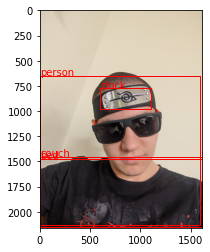

In [6]:
image = utils.read_image('/kaggle/input/fruits/AuFr8SAjKGs.jpg')
model = core.Model()

labels, boxes, scores = model.predict_top(image)
visualize.show_labeled_image(image, boxes, labels)

In [7]:
data_dir = '/kaggle/input/fruits'
image_paths = [data_dir + '/' + f for f in sorted(os.listdir(data_dir)) if f.split('.')[1] == 'jpg' or
                                                                           f.split('.')[1] == 'jpeg']

0it [00:00, ?it/s]

CPU times: user 2.64 s, sys: 335 ms, total: 2.98 s
Wall time: 3.03 s


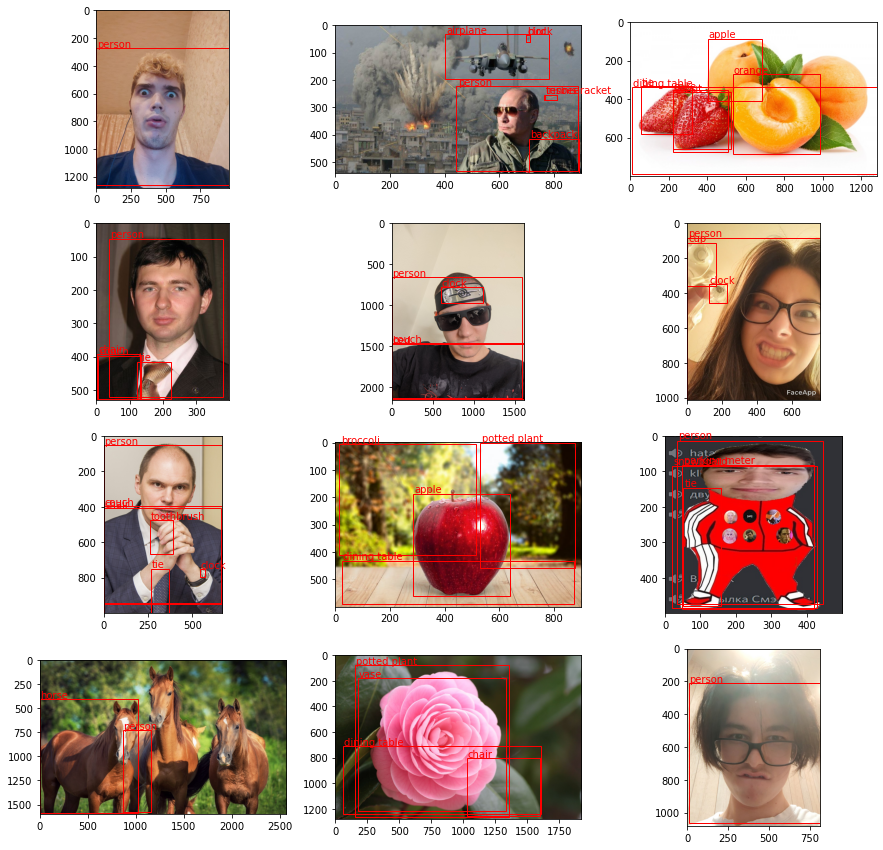

In [7]:
%%time

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
ax = ax.flatten()

model = core.Model()

for i, path in tqdm(enumerate(image_paths)):
    image = utils.read_image(path)
    labels, boxes, scores = model.predict_top(image)
    show_labeled_image(ax[i], image, boxes, labels)


Скачиваем данные, на которых будем обучаться.

In [8]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Szc920DAh5kU8Qk38Doq0znEVR1QmTZS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Szc920DAh5kU8Qk38Doq0znEVR1QmTZS" -O OD-WeaponDetection-master.zip && rm -rf /tmp/cookies.txt
!sudo apt install unzip
!unzip -q OD-WeaponDetection-master.zip

--2023-01-03 06:47:34--  https://docs.google.com/uc?export=download&confirm=t&id=1Szc920DAh5kU8Qk38Doq0znEVR1QmTZS
Resolving docs.google.com (docs.google.com)... 74.125.28.100, 74.125.28.139, 74.125.28.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.28.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m90vfs0644069ll3d3lj9nfttgautq29/1672728450000/03762575418546638964/*/1Szc920DAh5kU8Qk38Doq0znEVR1QmTZS?e=download&uuid=44a4ac6d-d749-4cd2-b693-a712970af291 [following]
--2023-01-03 06:47:35--  https://doc-0o-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m90vfs0644069ll3d3lj9nfttgautq29/1672728450000/03762575418546638964/*/1Szc920DAh5kU8Qk38Doq0znEVR1QmTZS?e=download&uuid=44a4ac6d-d749-4cd2-b693-a712970af291
Resolving doc-0o-0k-docs.googleusercontent.com (doc-0o-0k-docs.googleusercontent.com)... 172.217.204.132, 260

Удобно сразу сделать перевод `xml` файлов с данными об изображениях в один `csv` файл.

In [9]:
def xml_to_csv(label_dir, image_dir, output_file=None):
    
    names_of_images = [f for f in sorted(os.listdir(image_dir))]
    xml_list = []
    image_id = 0
    # Loop through every XML file
    for xml_file in glob(label_dir + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        if filename not in names_of_images:
            continue

        # Each object represents each actual image label
        for member in root.findall('object'):
            box = member.find('bndbox')
            label = member.find('name').text

            # Add image file name, image size, label, and box coordinates to CSV file
            row = (filename, width, height, label, int(float(box.find('xmin').text)),
                   int(float(box.find('ymin').text)), int(float(box.find('xmax').text)), int(float(box.find('ymax').text)), image_id)
            xml_list.append(row)
        
        image_id += 1

    # Save as a CSV file
    column_names = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'image_id']
    xml_df = pd.DataFrame(xml_list, columns=column_names)

    if output_file is not None:
        xml_df.to_csv(output_file, index=None)

    return xml_df

In [10]:
train_image_dir = '/kaggle/working/OD-WeaponDetection-master/Weapons and similar handled objects/Sohas_weapon-Detection/images/'
train_label_dir = '/kaggle/working/OD-WeaponDetection-master/Weapons and similar handled objects/Sohas_weapon-Detection/annotations/xmls/'
train_label_csv_dir = '/kaggle/working/train_labels.csv'
df = xml_to_csv(train_label_dir, train_image_dir, output_file=train_label_csv_dir)

In [11]:
test_image_dir = '/kaggle/working/OD-WeaponDetection-master/Weapons and similar handled objects/Sohas_weapon-Detection/images_test/'
test_label_dir = '/kaggle/working/OD-WeaponDetection-master/Weapons and similar handled objects/Sohas_weapon-Detection/annotations_test/xmls/'
test_label_csv_dir = '/kaggle/working/test_labels.csv'
df = xml_to_csv(test_label_dir, test_image_dir, output_file=test_label_csv_dir)

Датасет тоже взят из `Detecto`, но в нем была проблема с аугментациями, так как `bound box` различных изображений при отражении по горизонтали, к примеру, при отрисовке оказывался не там. В итоге, я решил просто применить библиотеку `Augmentation`, в которой это всё сделано автоматически.

In [12]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, label_data, image_folder=None, transforms=None):

        self._csv = pd.read_csv(label_data)

        # If image folder not given, set it to labels folder
        if image_folder is None:
            self._root_dir = label_data
        else:
            self._root_dir = image_folder

        self.transforms = transforms

    # Returns the length of this dataset
    def __len__(self):
        # number of entries == number of unique image_ids in csv.
        return len(self._csv['image_id'].unique().tolist())

    # Is what allows you to index the dataset, e.g. dataset[0]
    # dataset[index] returns a tuple containing the image and the targets dict
    def __getitem__(self, idx):
    
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read in the image from the file name in the 0th column
        object_entries = self._csv.loc[self._csv['image_id'] == idx]

        img_name = os.path.join(self._root_dir, object_entries.iloc[0, 0])
        image = read_image(img_name)

        boxes = []
        labels = []
        for object_idx, row in object_entries.iterrows():
            # Read in xmin, ymin, xmax, and ymax
            box = self._csv.iloc[object_idx, 4:8]
            boxes.append(box)
            # Read in the labe
            label = self._csv.iloc[object_idx, 3]
            labels.append(label)

        boxes = torch.tensor(boxes).view(-1, 4)

        targets = {'boxes': boxes, 'labels': labels}

        # Perform transformations
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=targets['boxes'], class_labels=targets['labels'])
            image = transformed['image']
            targets['boxes'] = torch.tensor(transformed['bboxes'])
            targets['labels'] = transformed['class_labels']

        return image, targets


In [13]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

train_transforms = A.Compose([
                             A.OneOf([
                                 A.HorizontalFlip(p=1),
                                 A.RandomRotate90(p=1),
                                 A.VerticalFlip(p=1)
                                 ], p=0.5),
                             A.OneOf([
                                 A.RandomBrightnessContrast(p=1),
                                 A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=1),
                                 A.ToGray (p=1)
                                 ], p=0.3),
                             A.OneOf([
                                     A.Blur(blur_limit=(7 ,11), p=1),
                                     A.MedianBlur(blur_limit=(7 ,11), p=1)
                                     ], p=0.2),
                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                             ToTensorV2()],
                             bbox_params=A.BboxParams(format='pascal_voc',
                                                      label_fields=['class_labels']))
test_transforms = A.Compose([
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()],
                            bbox_params=A.BboxParams(format='pascal_voc',
                                                     label_fields=['class_labels']))

train_dataset = MyDataset(train_label_csv_dir, train_image_dir, transforms=train_transforms)
val_dataset = MyDataset(test_label_csv_dir, test_image_dir, transforms=test_transforms)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False) 
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

Класс модели также был написан в библиотеке `Detecto`, но там не было вывода графиков вовремя обучения, что не позволяет оценить: вообще модель обучается или нет. Поэтому я чуть изменил функцию `fit`, чтобы видеть изменение побатчевого лосса и лосса с течением эпох валидации и трейна.

In [14]:
class NewModel(Model):
    
    DEFAULT = 'fasterrcnn_resnet50_fpn'
    MOBILENET = 'fasterrcnn_mobilenet_v3_large_fpn'
    MOBILENET_320 = 'fasterrcnn_mobilenet_v3_large_320_fpn'
    
    def __init__(self, classes=None, device=None, pretrained=True, model_name=DEFAULT):
        super().__init__(classes, device, pretrained, model_name)
    
    def fit(self, dataset, optimizer, lr_scheduler, val_dataset=None, epochs=10,  verbose=True):

        if verbose and self._device == torch.device('cpu'):
            print('It looks like you\'re training your model on a CPU. '
                  'Consider switching to a GPU; otherwise, this method '
                  'can take hours upon hours or even days to finish. '
                  'For more information, see https://detecto.readthedocs.io/'
                  'en/latest/usage/quickstart.html#technical-requirements')

        if epochs > 0:
            self._disable_normalize = False

        # Convert dataset to data loader if not already
        if not isinstance(dataset, DataLoader):
            dataset = DataLoader(dataset, shuffle=True)

        if val_dataset is not None and not isinstance(val_dataset, DataLoader):
            val_dataset = DataLoader(val_dataset)

        train_losses = []
        val_losses = []
        best_loss = np.inf
        save_dir = '/kaggle/working/model_weights.pth'

        # Train on the entire dataset for the specified number of times (epochs)
        for epoch in range(epochs):
            if verbose:
                print('Epoch {} of {}'.format(epoch + 1, epochs))

            # Training step
            self._model.train()

            if verbose:
                print('Begin iterating over training dataset')

            iterable = tqdm(dataset, position=0, leave=True) if verbose else dataset
            batch_train_loss = []
            for images, targets in iterable:
                self._convert_to_int_labels(targets)
                images, targets = self._to_device(images, targets)

                loss_dict = self._model(images, targets)
                total_loss = sum(loss for loss in loss_dict.values())
                batch_train_loss += [total_loss.item()]

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

            avg_train_loss = np.mean(batch_train_loss)
            train_losses += [avg_train_loss]

            if val_dataset is not None:
                avg_val_loss = 0
                total_loss = 0
                with torch.no_grad():
                    if verbose:
                        print('Begin iterating over validation dataset')

                    iterable = tqdm(val_dataset, position=0, leave=True) if verbose else val_dataset
                    for images, targets in iterable:
                        self._convert_to_int_labels(targets)
                        images, targets = self._to_device(images, targets)
                        loss_dict = self._model(images, targets)
                        total_loss = sum(loss for loss in loss_dict.values())
                        avg_val_loss += total_loss.item()

                avg_val_loss /= len(val_dataset.dataset)
                val_losses += [avg_val_loss]

            if verbose:
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
                clear_output(True)
                ax[0].plot(batch_train_loss, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Train loss')
                if train_losses is not None:
                    ax[1].plot(train_losses, label='general train history')
                    ax[1].set_xlabel('Epoch')
                if val_losses is not None and val_dataset is not None:
                    ax[1].plot(val_losses, label='general test history')
                plt.legend()
                plt.show()
                
                if val_dataset is not None:
                    print(f"Train Loss: {avg_train_loss:.4f}, "
                          f"Test Loss: {avg_val_loss:.4f}, "
                          f"Number of epoch: {epoch + 1}")
                else:
                    print(f"Train Loss: {avg_train_loss:.4f}, "
                          f"Number of epoch: {epoch + 1}")
            
            if avg_train_loss < best_loss:
                best_loss = avg_val_loss
                self.save(save_dir)
            
            lr_scheduler.step()

        if len(train_losses) > 0:
            return train_losses
    
    def _to_cpu(self, preds, targets):
        preds = [{k: v.to(self._device) for k, v in t.items()} for t in preds]
        targets = [{k: v.to(self._device) for k, v in t.items()} for t in targets]
        return preds, targets
    
    @staticmethod
    def load(file, classes, model_name):
        model = NewModel(classes, model_name=model_name)
        model._model.load_state_dict(torch.load(file, map_location=model._device))
        return model

Функция MaP будет давать нам метрику, в основном использующуюся в задачах детекции. Написал я её просто: использовал готовую функцию библиотеки `torchmetrics`.

In [36]:
def MaP(model, dataloader):
    metric = MeanAveragePrecision()
    iterable = tqdm(dataloader, position=0, leave=True)
    with torch.no_grad():
        for images, targets in iterable:
            model._convert_to_int_labels(targets)
            images, targets = model._to_device(images, targets)
            predicts = model.predict_top(images)

            preds = [{'boxes': predict[1],
                      'scores': predict[2],
                      'labels': predict[0]} for predict in predicts]

            model._convert_to_int_labels(preds)
            preds, targets = model._to_cpu(preds, targets)
            metric.update(preds, targets)

    return metric.compute()

В обучении как оказалось в итоге лучше всего использовать обычный стохастический градиентный спуск, так как, начиная использовать, напирмер, `Adam` лосс будет идти только вверх. Наверное, это связано с такой необычной поверхностью функции лосса.

In [17]:
learning_rate = 5e-3
lr_step_size = 5
gamma = 0.1
weight_decay = 5e-4
momentum = 0.9

model = NewModel(['pistol', 'knife', 'billete', 'monedero', 'smartphone', 'tarjeta'])
parameters = [p for p in model._model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=gamma)

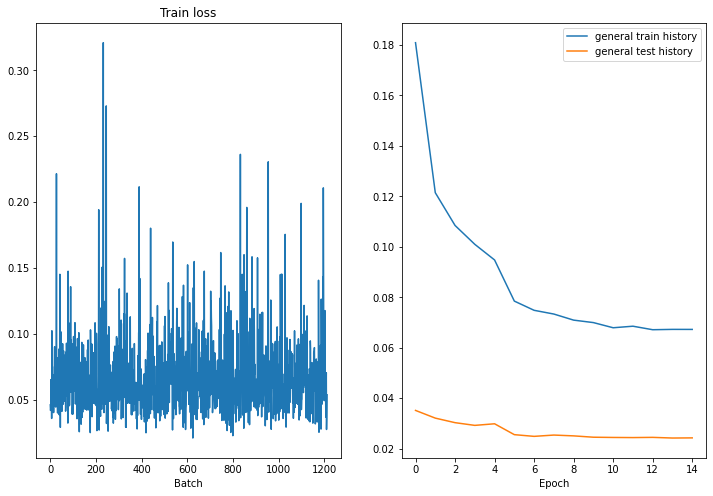

Train Loss: 0.0673, Test Loss: 0.0243, Number of epoch: 15


In [18]:
losses = model.fit(train_loader, optimizer, lr_scheduler, val_loader, epochs=15, verbose=True)

In [19]:
save_dir = '/kaggle/working/model_weights.pth'
model.save(save_dir)

Посмотрим результаты на моих фотографиях и фотографиях с валидационного датасета.

2it [00:00,  9.42it/s]


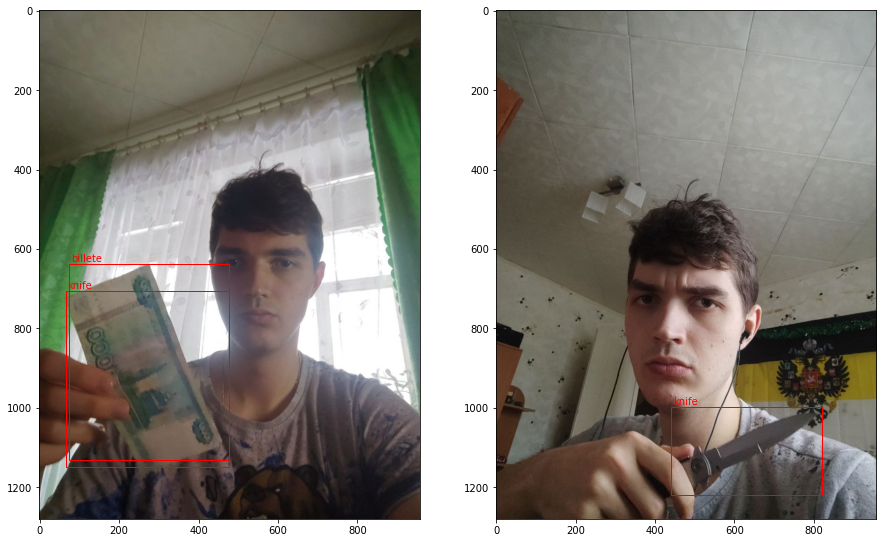

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax = ax.flatten()

images = [utils.read_image('/kaggle/input/fruits/photo_2023-01-01_14-56-32.jpg'),
         utils.read_image('/kaggle/input/fruits/photo_2023-01-01_14-50-43.jpg')]

for i, image in tqdm(enumerate(images)):
    labels, boxes, scores = model.predict_top(image)
    show_labeled_image(ax[i], image, boxes, labels)

12it [00:02,  4.21it/s]


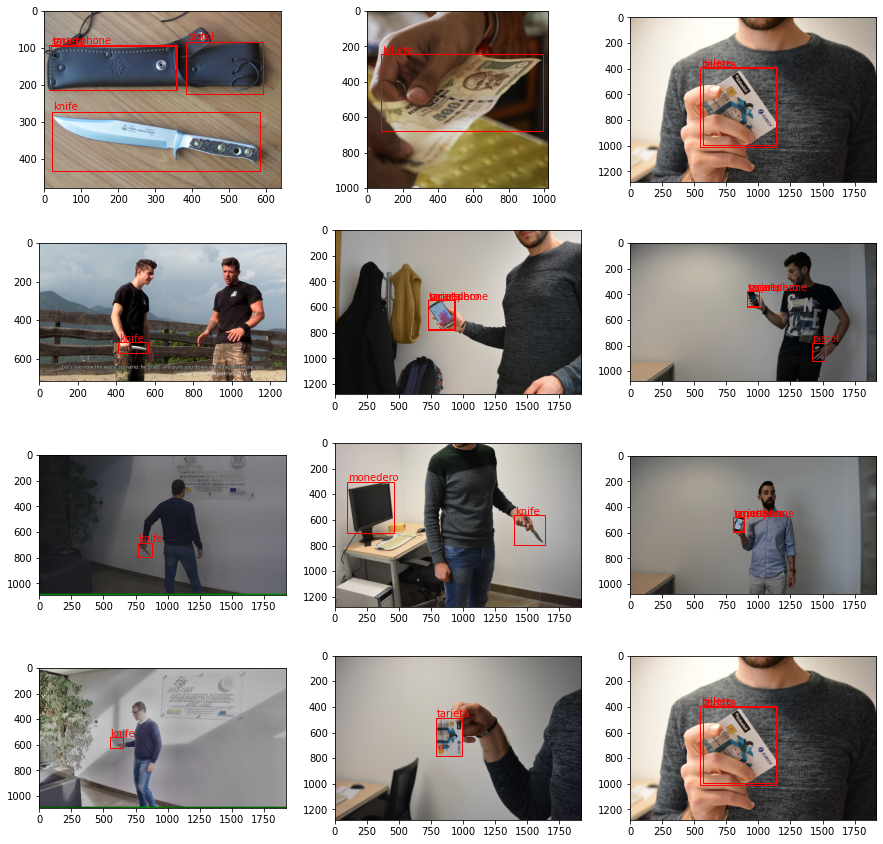

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
indxs = np.random.choice(np.array(len(val_dataset)), 12)
ax = ax.flatten()

for i, indx in tqdm(enumerate(indxs)):
    labels, boxes, scores = model.predict_top(val_dataset[indx][0])
    show_labeled_image(ax[i], val_dataset[indx][0], boxes, labels)

В целом модель находит объекты на фотографии и достаточно неплохо. Единственное, что она часто накрадывает боксы друг на друга. Может стоить делать более жесткую фильтрацию по уверенности.

Посмотрим на значение метрики MaP.

In [35]:
metric = MaP(model, val_loader)

100%|██████████| 208/208 [01:29<00:00,  2.32it/s]


In [37]:
metric

{'map': tensor(0.6765),
 'map_50': tensor(0.9004),
 'map_75': tensor(0.7826),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.4914),
 'map_large': tensor(0.7083),
 'mar_1': tensor(0.7361),
 'mar_10': tensor(0.7361),
 'mar_100': tensor(0.7361),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.5450),
 'mar_large': tensor(0.7630),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [41]:
metric['map'].item()

0.6765334010124207

Метрика показала достаточно высокий результат 0,68. По сравнению с тем, что я получал когда-то, обучая с нуля модель YOLO, это просто шик. Да и по фотографиям видно, что он координаты нужных боксов ставит очень близко к тому, что было в обучающем датасете.